## Customer Lifetime Value

## Customer Lifetime Value (CLV) = how much a company expects to earn from an average customer in a life time.

CLV allows to benchmark customers and identify how much money the company can afford to spend on customer acquisition.

Historical CLV = the sum of revenues of all customer transactions multiplied by average or product-level profit margin

Problems with historical CLV:

doesn't account for customer tenure, retention or churn (e.g. if the company is growing its customer base, historical CLV will be deflated due to short tenure)
doesn't account for new customers and their future revenue
Basic CLV = Average Revenue Profit Margin Average Lifespan
(where Average Lifespan is e.g. average time before customer churn)

Granular CLV = (Average Revenue per Transaction Average Frequency Profit Margin) * Average Lifespan
(where Avg Frequency is within the certain timeframe, e.g. a month)
accounts for each transaction

Traditional CLV = (Average Revenue Profit Margin) Retention Rate / Churn Rate
(where Churn = 1 - Retention Rate)
Retention/Churn - a proxy of expected length of customer lifespan with the company
account for customer loyalty assumes that churn is final and customers do not return (especially critical for non-contractual business models)

Because we don't have profit margin, we will calculate revenue-based CLV.

But before calculating Basic, Granular and Traditional CLV, we will load, explore the data and then calculate retention rates using cohort analysis. We will need retention rates and churn rates for calculating Traditional CLV later.

In [25]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt
import tensorflow as tf

#Import Data
tx_data=pd.read_csv("OnlineRetail.csv", encoding="cp1252")
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
#Check the shape (number of columns and rows) in the dataset
tx_data.shape

(541909, 8)

In [3]:
#Find out missing values
tx_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## CLEANING OF DATA SETS

In [4]:
#Remove time from date
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

#There are 135,080 missing values in the CustomerID column, and since our analysis is based on customers, 
#we will remove these missing values.
tx_data = tx_data[pd.notnull(tx_data['CustomerID'])]

#Keep records with non negative quantity
tx_data = tx_data[(tx_data['Quantity']>0)]

#Add a new column depicting total sales
tx_data['Total_Sales'] = tx_data['Quantity'] * tx_data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
tx_data = tx_data[necessary_cols]
tx_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [5]:

#Print records pertaining unique Customer IDs
print(tx_data['CustomerID'].nunique())

4339


In [6]:

#Check the Last order date
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12346)])

2011-12-09
--------------------------------------
       CustomerID InvoiceDate  Total_Sales
61619     12346.0  2011-01-18      77183.6


In [10]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.7 %


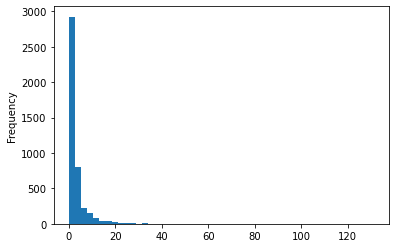

In [11]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [12]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [13]:

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


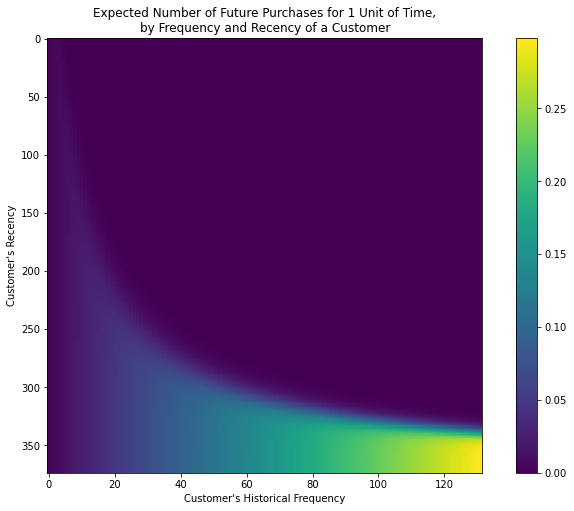

In [14]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

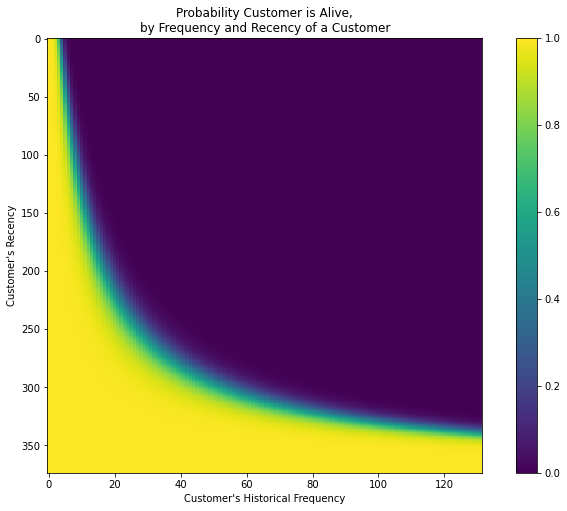

In [15]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [16]:
#Predict future tranon in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, bassactied on historical data

t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


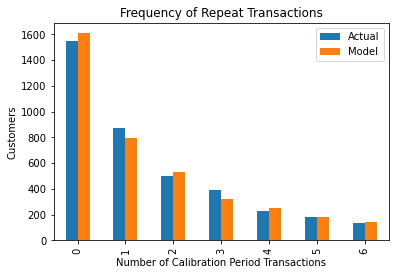

In [17]:

#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [18]:

#Customer's future transaction prediction for next 10 days

t = 10
individual = lf_tx_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 3 in 10 days.

2.9830238639023574

In [19]:

#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_tx_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [20]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are:  2790


In [21]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [22]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [23]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [24]:
#Calculate Customer Lifetime Value
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)

lf_tx_data.sort_values(by='CLV', ascending=False).head(10).reset_index()

,CustomerID,CLV
0,14646.0,222128.93
1,18102.0,178895.33
2,16446.0,175531.47
3,17450.0,147476.62
4,14096.0,127589.20
5,14911.0,109442.13
6,12415.0,96290.23
7,14156.0,89410.33
8,17511.0,67660.41
9,16029.0,58729.62
